# Distancia entre elementos
    - Para abordar los temas de escalamiento multidimensional y análisis de conglomerados, es necesario introducir el concepto de distancia.
    
    - También se les conoce como métricas
    
    - Cuando existen dos sujetos muy similares su distancia será pequeña. Por el contrario, cuando sean muy distintos, la distancia será grande.

In [14]:
# Employed libraries
import scipy
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2
import pandas as pd
import scipy.stats.contingency as ctgy

### 1] Distancia entre variables continuas
    - La medida de distancia más común entre dos elementos, medida para una variable continua, es la DISTANCIA EUCLIDIANA, la cual se calcula cómo:

        d(x,y) = sqrt( (x1-y1)^2 + ... + (xp-yp)^2 )
            donde:
            x, y: Elementos con observaciones en p variables
            x = (x1, x2, x3, ..., xp)
            y = (y1, y2, y3, ..., yp)
            
    - Una generalización de la distancia euclidana es definir el coeficiente alpha tal que
    
        d(x,y) = (sum[i in p]((xi-yi)^alpha))^(1/alpha)
            donde:
            xi,yi: Observación en la variable i de los elementos x y y
            alpha: Coeficiente para definir la distancia
            Nota: Observe que si alpha=2, la distancia será la euclidiana
            
    - Otra métrica comunmente usada es la DISTANCIA DE MAHALANOBIS, que se define matricialmente como:

        d(x,y) = [x-y]' * [S]^-1 * [x-y]
            donde:
            [x-y]: Matriz con las diferencias entre las medidas
            []': Transpuesta de la matriz
            [S]^-1: Inversa de la matriz de covarianzas
            Nota: En algunas ocasiones no puede ser calculada debido a que la matriz de covarianza no cumple
            con ser positiva semidefinida

In [2]:
# Define a dataset
x = np.round(norm.rvs(size=2, loc=0, scale=1),4)
y = np.round(norm.rvs(size=2, loc=0, scale=1),4)

# Euclidean distance
d_euc = ( (x-y)**2 ).sum()**0.5

# Mahalanobis distance
S = np.linalg.inv( np.cov(np.stack([x,y],axis=1), ddof=0) )
d_mah = ( (x-y).T @ (S@x-y) )**0.5
# d_mah = scipy.spatial.distance.mahalanobis(x,y,S)

# Output
print("="*100)
print("Elemento x:\n",x)
print("Elemento y:\n",y)
print("\nDistancia euclideana:",np.round(d_euc,2))
print("Distancia de Mahalanobis:",np.round(d_mah,2))
print("="*100)

Elemento x:
 [1.1616 1.2473]
Elemento y:
 [0.3219 1.0975]

Distancia euclideana: 0.85
Distancia de Mahalanobis: 5.66


### 2] Distancia de Mahalanobis para detectar outliers multidimensionalmente
    - Debido a que la distancia de Mahalanobis emplea la matriz de covarianzas, puede detectar en qué dimensiones es más o menos castigable moverse para aumentar la distancia. Es decir, que si hay menos varianza en una variable, alejarse una unidad del centroide es estar "más lejos" que si se aleja una unidad en una variable con mucha varianza.
    
    - Las distancias se calculan con respecto al centroide. Note que si se calcularan las euclidianas, no sería posible considerar la importancia de la varianza en cada dimensión.
    
    - Para la detección de outliers se debe establecer un límite de confianza. La función Chi cuadrada con p grados de libertad es con la que se obtiene el p-value que será la distancia de confianza.
    
        d_conf^2 = chi2[df=p].ddof(0.95)
            donde:
            d_conf: Distancia de confianza
            chi2: Distribución chi cuadrada
            ddof: Inversa de la distribución estandarizada
            df: Grados de libertad

La distancia de confianza es: 2.716


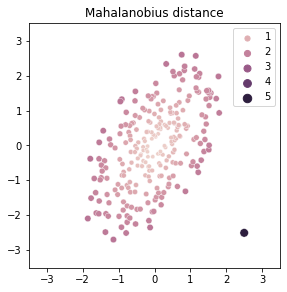

In [24]:
# General settings for ellipse
n_points = 250
rx = 6
ry = 3
rotate = np.pi * (-1/3)
random = np.random.uniform(low=0.1, high=1, size=n_points)
theta = np.linspace(0, 2*np.pi, num=n_points)

# Generate XY points of ellipse
x,y = np.zeros(n_points),np.zeros(n_points)
for i in range(len(theta)):
    x[i] = rx/2*random[i]*np.cos(theta[i])
    y[i] = ry/2*random[i]*np.sin(theta[i])
    
# Rotate ellipse
rot_mx = np.array([[np.cos(rotate),-np.sin(rotate)],[np.sin(rotate),np.cos(rotate)]])
coords = np.stack([x,y],axis=1)
coords = coords @ rot_mx

# Make an observation an outlier
coords[0] = [2.5,-2.5]

# Centroid
centroid = coords.mean(0)
centered = coords - centroid

# Covariance matrix
S = np.cov(coords,rowvar=False)
S_inv = np.linalg.inv(S)

# Mahalanobius distances
d_mah = np.diag(centered @ (S_inv@centered.T))**0.5

# Plot ellipse
sns.scatterplot(x=coords[:,0],y=coords[:,1],hue=d_mah,size=d_mah).set(
    xlim=(-3.5,3.5),ylim=(-3.5,3.5), title="Mahalanobius distance")

# Confidence distance
d_mah_conf = chi2.ppf(0.975,df=2)**0.5
print("="*100)
print("La distancia de confianza es:",round(d_mah_conf,3))
print("="*100)

### 3] Disimilitudes entre datos binarios
    - La disimilitud es una medida parecida a la distancia, pero que no cumple con todas las propiedades con las que cuentan las distancias. Sin embargo, sigue siendo sumamente útil.

    - La distancia entre dos elementos (x,y) cuyas observaciones son todas binarias se basa en contar las ocurrencias:
    
        a = sum[i in p](xi=1 and yi=1)
        b = sum[i in p](xi=1 and yi=0)
        c = sum[i in p](xi=0 and yi=1)
        d = sum[i in p](xi=0 and yi=0)
        
    - Después, se calcula la disimilitud entre (x,y). Observe que la distancia máxima será de 1 y la mínima 0. Entonces, dos elementos idénticos tendrán distanca 0, mientras que elementos totalmente diferentes, de 1:

        d(x,y) = 1 - c(x/y) = (b+c)/p
        
        c(x,y) = (a + d)/p = (count(1,1) + count(0,0))/p = count(coincidencias)/p
            donde:
            c(xy): Similitud entre los elementos (x,y)
            d(xy): Disimilitud entre los elementos (x,y)
            
    - Sin embargo, existe una corriente que sostiene que no deben considerarse las coincidencias en (0,0), por lo que se modifica la forma de calcular la distanca:
    
        - Coeficiente de Jaccard:

            d(x,y) = (b+c)/(a+b+c)
            
        - Coeficiente de Czekanowski
            
            d(x,y) = (b+c)/(2a+b+c)
                Nota: Observe que al multiplicar 2a, se intenta compensar el hecho de que se elimino d

In [84]:
# Define a data set
values = np.random.randint(2,size=(2,10))
x = values[0,:]
y = values[1,:]
a = ((x==1)*(y==1)).sum()
b = ((x==1)*(y==0)).sum()
c = ((x==0)*(y==1)).sum()
d = ((x==0)*(y==0)).sum()

# Calculate distance
sim = (x==y).sum(0) / x.shape[0]
dis = round(1 - sim,2)

# Alternative measures
d_jac = round((b+c)/(a+b+c),2)
d_cze = round((b+c)/(2*a+b+c),2)

# Output
print("="*100)
print("Distancia:",dis)
print("Distancia de Jaccard:",d_jac)
print("Distancia de Czekanowski:",d_cze)
print("="*100)

Distancia: 0.7
Distancia de Jaccard: 1.0
Distancia de Czekanowski: 1.0


### 4] Disimilitudes entre variables categóricas
    - Se miden a través de una similitud para después calcular una disimilitud. El coeficiente de Sneath se calcula como:
    
    c(x,y) = a / p
    
    d(x,y) = 1- c(x,y)
        donde:
        a: Número de atributos en que las unidades coinciden        

In [108]:
# Define a dataset
fruit = ["apple", "orange", "peach"]
color = ["red", "green", "blue"]
animal = ["snake", "dog", "cat"]
indices = np.random.randint(3,size=(2,3))
x = np.array([fruit[indices[0,0]], color[indices[0,1]], animal[indices[0,2]]])
y = np.array([fruit[indices[1,0]], color[indices[1,1]], animal[indices[1,2]]])

# Compute distance
d_sne = 1-(x==y).sum() / len(x)

print("="*100)
print("Distancia de Sneath:",round(d_sne,2))
print("="*100)

Distancia de Sneath: 0.33


### 5] Índice de Gower para distancias con múltiples tipos de variables
    - Permite comparar elementos considerando variables cuantiativas y cualitativas. La comparación se realiza al calcular similitud c(x,y) al ponderar equitativamente a las similitudes entre variables únicas s(x,y).
    
    - La distancia en el índice de Gower se calcula cómo:
    
        d(x,y) = 1 - c(x,y)
        
        c(x,y) = 1/p * sum[i in p](s_i(x,y))
            donde:
            d(x,y): Distancia calcula a través del índice de Gower
            c(x,y): Similitud en (x,y) promedio
            s_i(x,y): Similitud en (x,y) para la variable i
            
    - La forma de calcular s_i(x,y) depende del tipo de variable:
        
        Cuantiativa
        s_i(x,y) = 1 - abs(x_i-y_i) / (max(i)-min(i))
            donde:
            s_i: Similitud de la variable i entre (x,y)
            x_i: Observación de la variable i en (x)
            max(i): Máximo observado de la variable i
        
        Cualitativa
        s_i(x,y) = 1 if x==y else 0
            donde:
            s_i: Similitud de la variable i entre (x,y)
            Nota: Para el caso de variables binarias, esta configuración equivaldría a la fórmula donde se
            consideran coincidencias (0,0)

In [323]:
# Generate a dataset
# Cuantiative variables
x = norm.rvs(size=5,loc=10,scale=2)
y = norm.rvs(size=5,loc=10,scale=2)
z = norm.rvs(size=5,loc=10,scale=2)
xyz = np.stack((x,y,z), axis=0)
# Binary variables
x = np.concatenate([x,np.random.randint(2,size=5)])
y = np.concatenate([y,np.random.randint(2,size=5)])
# Categoric variables
categories = np.random.randint(3,size=(2,3))
x = np.concatenate([x,categories[0,]])
y = np.concatenate([y,categories[1,]])

# Compute distances for cuantiativa variables
sim = [1-abs(x[i]-y[i]) / (xyz[:,i].max()-xyz[:,i].min()) for i in range(5)]

# Compute distances for binary variables
sim += [int(x[i]==y[i]) for i in range(5,10)]

# Compute distances for categorica variables
sim += [int(x[i]==y[i]) for i in range(10,13)]

# Compute Gower's index
d_gow = 1 - np.array(sim).mean(0)

print("="*100)
print("Indice (distancia) de Gower:",round(d_gow,2))
print("="*100)

Indice (distancia) de Gower: 0.68


### 6] Disimilitud entre variables

    Variables cuantitativas
    
    - La medida de correlación es utilizada para determinar la distancia entre variables. Variables con correlación cercana a 1 se consideran similares, por lo que su distancia deberá ser cercana a 0. Se tiene que decidir si variables con correlación -1 son cercanas o totalmente lejanas. Para considerar esta decisión en términos de distancia se utilizan las siguientes fórmulas:
    
        - d(X,Y) = 1 - ro^2
            donde:
            d(X,Y): Distancia entre las variables (X,Y)
            ro: Coeficiente de correlación de Pearson
            Nota: Observe que el rango de la distancia está entre 0 y 1
            
        - d(X,Y) = 1 - ro
            Nota: Observe que el rango de la distancia está entre 0 y 2. Podría normalizarse entre 0 y 1 al
            dividirlo entre 2
    
    
    Variables cualitativas
    
    - Para medir la distancia entre variables categóricas o binarias se hace uso de la medida de independencia de la prueba Chi2. Las variavles independientes se consideran alejadas una de la otra. Mientras que la dependencia entre variables sugiere cercanía entre ellas.
    
    - El estadístico Chi2 se construye a partir de comparar la distancia entre lo observado y lo esperado. Como la prueba es de independencia, lo esperado supone independencia. Entonces, P(Ai intersecc. Bj) = P(Ai) * P(Bj). La P(Ai) = count(Ai)/count(A). A tiene k cateogías y B tiene l categorías. La P(Bj). Por lo tanto, el número de elementos esperados en la intersección (Ai,Bj) es n*P(Ai)*P(Bj). El estadístico Chi2 se calcula como:
    
    Chi2 = sum[i in k][j in l]( (obs_ij - exp_ij)^2 / exp_ij)
        donde:
        obs_ij: Número de elementos observados en el cruce de categorías ij
        exp_ij: Número de elements esperados (expected) en el crude de categorías ij
        Nota: Para probar la independencia entre las variables, el estadístico de confianza es la inversa de
        Chi2 con (k-1)*(r-1) grados de ibertad.
        
    - Finalmente, la disimilitud entre las variables se computa como:

        d(X,Y) = 1 -(Chi2 / (n*min(k,l)-1))^0.5
            donde:
                Chi2: Estadístico de prueba
                n: Número de observaciones
                k,l: Número de categorías en las variables                

In [41]:
# Cuantitative variables
X = norm.rvs(size=10, loc=0, scale=2)
Y = X + norm.rvs(size=10, loc=0, scale=2)
ro = np.corrcoef(X,Y)[0,1]
d_cuant = 1 - ro**2

# Cualitative variables
# Define a dataset
cat_1_names = {i: j for i,j in enumerate(["Dog","Cat","Fish","Snake","Lion"])}
cat_1 = pd.Series(np.random.randint(5,size=150)).map(cat_1_names)
cat_2_names = {i: j for i,j in enumerate(["Red","Green","Blue"])}
cat_2 = pd.Series(np.random.randint(3,size=150)).map(cat_2_names)

# Generate contingency table
ctgy_table = cgy.crosstab(cat_1,cat_2)[1]
# Calculate Chi Squared statistic
chi2_stat = ctgy.chi2_contingency(ctgy_table)[0]
# Calculate dissimilarity
d_cual = 1 - (chi2_stat / (150*(min(5,3)-1)))**0.5



print("="*100)
print("Disimilitud var. cuantitativas:",round(d_cuant,2))
print("Disimilitud var. cualitativas:",round(d_cual,2))
print("="*100)

Disimilitud var. cuantitativas: 0.38
Disimilitud var. cualitativas: 0.89
